Notes
- Do not blindly hit run all; check what you need first
- Restart kernel before re-running code
- Explicit laser off command at the bottom of the page
- When conducting test, ensure that the correct blocks are running

In [1]:
import numpy as np
import pathlib
import pyvisa
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime
import threading
import pandas as pd
import os

TODAY_STR = datetime.now().strftime("%d.%m.%Y") # Format the date as DD.MM.YYYY
print(f"\x1b[1;3;4;96mDate of running the code:\x1b[0m \x1b[1;3;4;92m{TODAY_STR}\x1b[0m")
print(f"Time of running the code: {datetime.now().strftime("%H:%M:%S")}")
print("\x1b[1;31mWait for it...\x1b[0m")

# Device communication - must always be run
rm = pyvisa.ResourceManager()
rm.list_resources()   
print("PyVisa running nominally")

Date of running the code: 18.11.2024
Time of running the code: 17:46:54
Wait for it...
PyVisa running nominally


In [2]:
# # Laser connection. Laser is TSL
is_connect_success = False 
while not is_connect_success:
    try:
        TSL = rm.open_resource("TCPIP::169.254.82.30::5000::SOCKET", read_termination="\r")
        print(TSL.query("*IDN?"))
        print("\x1b[0;92mTSL Connection established\x1b[0m")
        is_connect_success = True
    except pyvisa.VisaIOError:
        print("Retrying...")
        time.sleep(0.5)

# if TSL.query(":POWer:STATe?") == "+0":
#     TSL.write(":POWer:STATe 1")
#     print("Laser was off. Laser turning on/warming up. 5 minute sleep has begun.\n\x1b[1;31mIf already on, restart kernel and re-run.\x1b[0m")
#     time.sleep(300) # 5 minute laser warm up, if necessary
#     print("5 minutes has passed; laser warmed up.")

# else:
#     print("\x1b[1;31mLaser on and ready.\x1b[0m")

SANTEC,TSL-570,24070004,0026.0026.0011
TSL Connection established


In [ ]:
# # oscilloscope connection
# Open the connection to the oscilloscope using its IP address
oscilloscope = rm.open_resource('TCPIP::169.254.112.67::INSTR', open_timeout=5000) # For the RIGOL DHO1204 in A*STAR

# Send a command to verify connection (e.g., identify the instrument)
# Sanity check for successful communication with oscilloscope
response = oscilloscope.query('*IDN?')
print(response, end='')
print("\x1b[0;92mOscilloscope Connection established.\x1b[0m")

# # Oscilloscope configure settings
oscilloscope.write(':TIMebase:ROLL 0')      # Turn off roll

oscilloscope.write(':ACQuire:MDEPth 1M')    # Check again if this command is working! If not manually set MemDepth

oscilloscope.write(':TIMebase:MAIN:SCALe 1')      # This is limited to certain values! Check manual!
oscilloscope.write(':TIMebase:MAIN:OFFSet 0')

oscilloscope.write(':CHANnel1:SCALe 3')         
oscilloscope.write(':CHANnel1:OFFSet 0')

oscilloscope.write(':CHANnel2:SCALe 0.04')      
oscilloscope.write(':CHANnel2:OFFSet -90e-3')       # For viewing clarity

oscilloscope.write(':CHANnel1:DISPlay 1')       # Turn on display of channel 1
oscilloscope.write(':CHANnel2:DISPlay 1')       # Turn on display of channel 2

print("Oscilloscope settings configured.\n\x1b[1;31mCheck settings again on oscilloscope screen, rerun cell if wrong.\x1b[0m")

RIGOL TECHNOLOGIES,DHO1204,HDO1B261900518,00.02.12
Oscilloscope Connection established.
Oscilloscope settings configured.
Check setting again on oscilloscope screen, rerun cell if wrong.


In [ ]:
# Always run this - needed for later data processing
# # Laser wavelength settings: Set parameters for wavelength sweep
WAV_START = 1535
WAV_END = 1540
speed = 2                    # Sweep speed (units of nm/s)
step_size = "10pm"             # step size of sweep. Read TSL manual pg 42/113 for minimum step size based on speed
delay_between_sweeps = 0.5
set_laser_power = 10            # Setting the laser power in dBm

print("\x1b[0;92mLaser settings configured\x1b[0m") 

Laser settings configured


Code below was for old laser implementation; new implementation shuts off the laser after sufficient data is collected. Leave commented out below.

In [ ]:
# # # Settings implementation - if laser already running, leave this
# TSL.write(f":POW {set_laser_power}")
# power_in_dbm = TSL.query(":POW?")
# # print(f"Laser power set to {round(float(power_in_dbm), 2)} dBm")

# TSL.write(":WAVelength:SWEep 0")  # Engineering reset
# time.sleep(0.1)

# # Parameter writing
# TSL.write(f":WAVelength:SWEep:STARt {WAV_START}E-9") # Set start wavelength
# time.sleep(0.1)
# TSL.write(f":WAVelength:SWEep:STOP {WAV_END}E-9")   # Set stop wavelength
# time.sleep(0.1)

# TSL.write(f":WAVelength:SWEep:SPEed {speed}")  
# time.sleep(0.1)

# TSL.write(":WAVelength:SWEep:MODe 1")   # Continuous and one-way sweep, for finest wavelength change per unit time.
# time.sleep(0.1)

# TSL.write("TRIG:OUTP:STEP " + step_size)        # Time between triggers
# time.sleep(0.1)
# # print(TSL.query("TRIG:OUTP:STEP?")) 
# # time.sleep(0.1) 

# TSL.write(f"WAVelength:SWEep:DELay {delay_between_sweeps}")  # Reduce the delay between sweeps
# time.sleep(0.1)
# # print(TSL.query("WAVelength:SWEep:DELay?"))  # Reduce the delay between sweeps
# # time.sleep(0.1) 

# # Begin sweeping
# TSL.write(":WAVelength:SWEep 1")        
# time.sleep(0.1)

# # print(f"""Sweeping initiated: 
# #       \n {WAV_START}nm to {WAV_END}nm at {round(float(power_in_dbm), 2)}dBm
# #       \n Trigger step size of {step_size} and speed {speed}nm/s, 
# #       \n Delay of {delay_between_sweeps}s between sweeps.""")

Code below is for manual triggering, single shot. Commented out for now.

In [ ]:
# # # Data collection of optical absorption

# def setup_trigger(trigger_level, trigger_source='CHAN1'):
#     """Function to set up and enable triggering"""
#     # Set the trigger source (e.g., Channel 1)
#     oscilloscope.write(f':TRIGger:EDGE:SOURce {trigger_source}')
#     # Set the trigger level (e.g., 0.5V)
#     oscilloscope.write(f':TRIGger:EDGE:LEVel {trigger_level}')
#     # Set the trigger type (e.g., edge trigger on a rising edge)
#     oscilloscope.write(':TRIGger:EDGE:SLOPe POSitive')
#     # Set the trigger sweep mode
#     oscilloscope.write(':TRIGger:SWEep SINGle')
#     print(f"Trigger set to {trigger_level}V on {trigger_source}.")


# def plot_and_save_waveform(channels: list[int]):
#     """Function to save the waveform as CSV file. Plot for sanity check"""
#     for ch in channels:
#         # Select the channel
#         oscilloscope.write(f':WAV:SOUR CHAN{ch}')

#         # Set the waveform format to ASCII (can also use 'BYTE' or 'WORD' for binary)
#         oscilloscope.write(':WAV:FORM ASCII')

#         # Get the waveform data
#         print(f"Querying waveform data for channel {ch}")
#         data = oscilloscope.query(':WAV:DATA?')

#         # Parse the data (it's returned as a comma-separated string in ASCII mode)
#         waveform_data = np.array([float(i) for i in data.split(',')])
#         waveforms[f"waveform_ch{ch}"] = waveform_data

#         # Get the X-axis scale and position (Time per division, etc.)
#         x_increment = float(oscilloscope.query(':WAV:XINC?'))
#         x_origin = float(oscilloscope.query(':WAV:XOR?'))

#         # Generate the time axis
#         time_axis = np.linspace(x_origin, x_origin + x_increment * len(waveform_data), len(waveform_data))
#         waveforms[f"time_axis_ch{ch}"] = time_axis

#         # Generate a timestamp for the file name
#         timestamp = datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
#         if ch == 1:
#             csvfilename = f"C:/Users/groov/VSCode/CSV_Waveforms/{timestamp}_triggers_ch{ch}.csv"
#         elif ch == 2:
#             csvfilename = f"C:/Users/groov/VSCode/CSV_Waveforms/{timestamp}_optical_ch{ch}.csv"
#         # Save the waveform data to a CSV file
#         np.savetxt(csvfilename, np.column_stack((time_axis, waveform_data)), delimiter=",", header="Time, Amplitude")

#     # Plot the waveform for visualization and sanity check
#     plt.figure(figsize=(10, 6))
#     for ch in channels:
#         plt.plot(waveforms[f"time_axis_ch{ch}"],  waveforms[f"waveform_ch{ch}"], label=f"channel {ch}")
#     plt.title("Waveform from Channels " + ", ".join(str(ch) for ch in channels))
#     plt.xlabel("Time (s)")
#     plt.ylabel("Amplitude (V)")
#     plt.grid(True)
#     plt.legend()
#     # plt.savefig(f"waveform_channel_{channel}_{timestamp}.png")
#     plt.show()


# waveforms = {} # Initialise empty dictionary of waveforms

# oscilloscope.write(':STOP') # Quickly "engineering reset" the oscilloscope
# time.sleep(0.1) # Small delay to let oscilloscope settle before running and arming trigger

# oscilloscope.write(':RUN') # Need oscilloscope to start running before it can capture anything
# # The trigger will automatically start capturing once the trigger is detected

# setup_trigger(trigger_level=0.5, trigger_source='CHAN1')  # # Arm the trigger, Unit of trigger_level is V
# time.sleep(0.1) # Small delay to confirm trigger preparation
# # print("Trigger armed, ready to fire.")

# while 1:
#     if oscilloscope.query(':TRIGger:STATus?').strip() == 'TD':
#         print("Triggered! Starting capture; it will stop by itself.")
#         break

#     elif oscilloscope.query(':TRIGger:STATus?').strip() == 'WAIT':
#         # print("Waiting for trigger.\nIf the laser has fully swept, hit 'trigger' again.")
#         # time.sleep(10)  # Check status every 10 seconds
#         continue

#     else:
#         pass

# while 1:
#     if oscilloscope.query(':TRIGger:STATus?').strip() == 'STOP':
#         plot_and_save_waveform(channels=[1,2])       # TODO: Write in the list of channel numbers that we wish to plot and save
#         print("Frozen waveforms captured and saved as CSV")
#         break
    
#     else:
#         time.sleep(0.1)  # Small delay to prevent busy-waiting
#         pass


Code below is for continuous looping of automatic triggers. 

It has now become VERY long because of a lot of simultaneous loop processes that occur at various instances in the loop, including laser control and plotting. The bulk of the code is in here. 

Triggered! Starting capture; it will stop by itself.
Querying waveform data for channel 1
Querying waveform data for channel 2
Frozen waveforms captured and saved as CSV
Capture 10/10
Triggered! Starting capture; it will stop by itself.
Querying waveform data for channel 1
Querying waveform data for channel 2
Frozen waveforms captured and saved as CSV


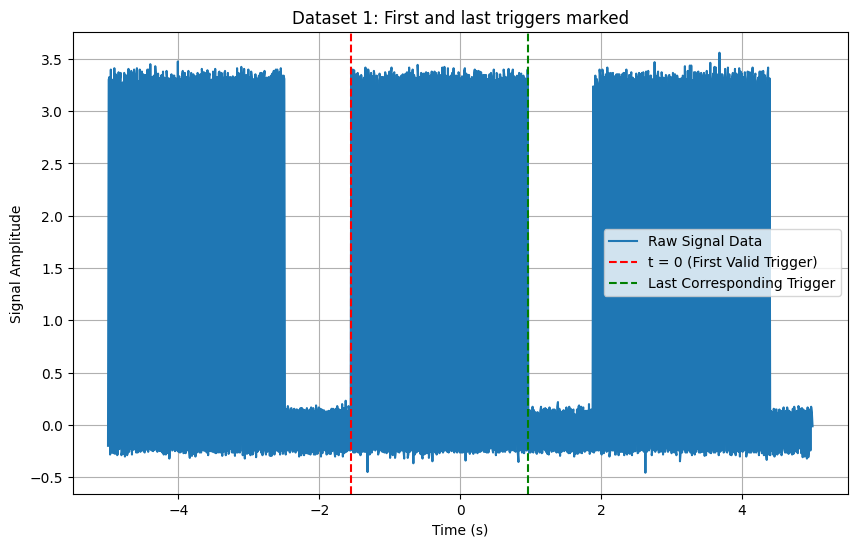

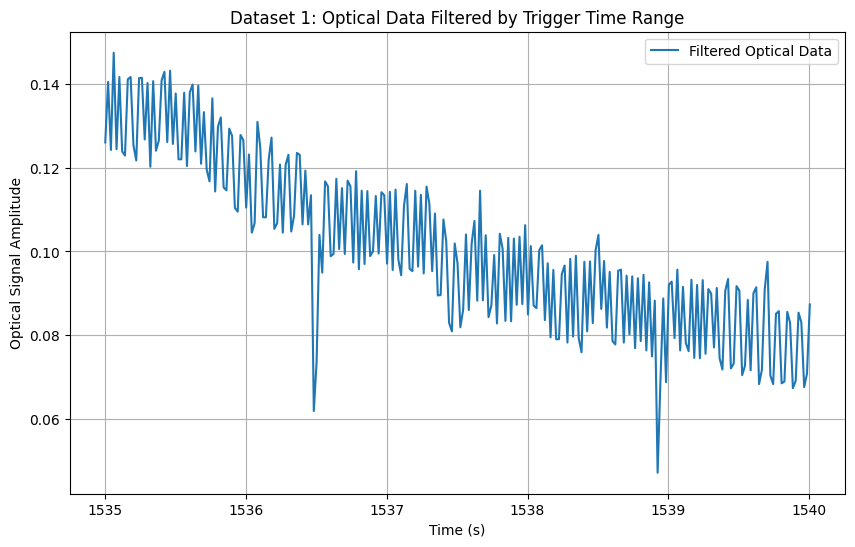

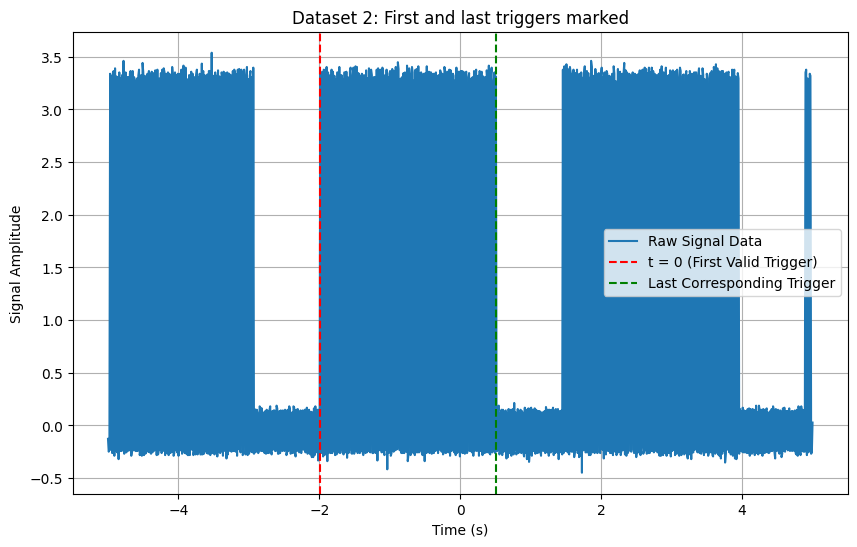

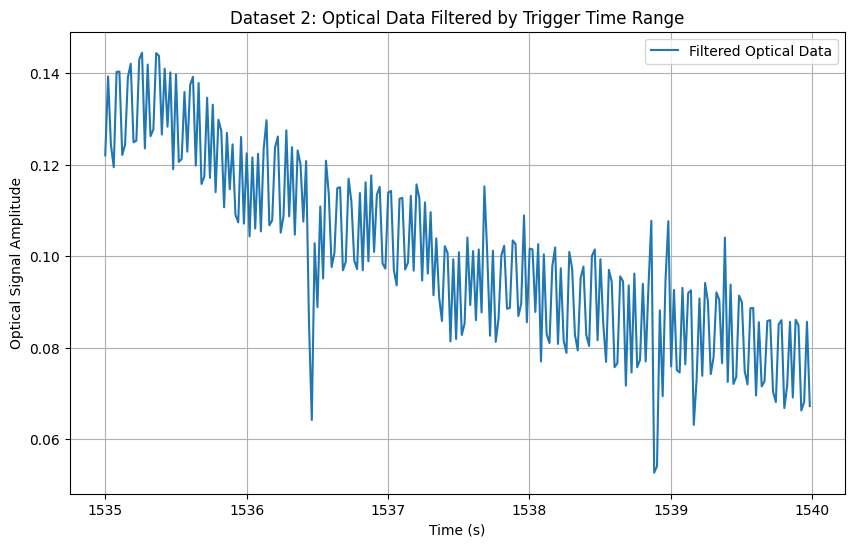

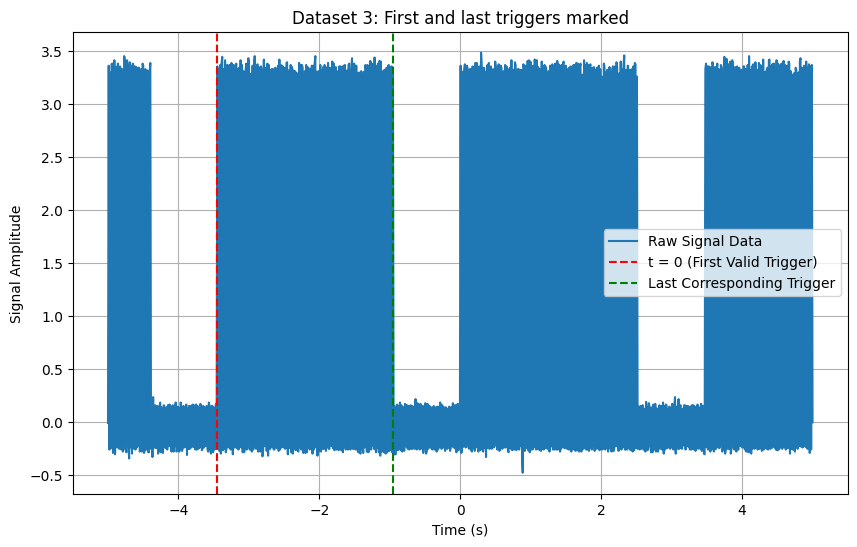

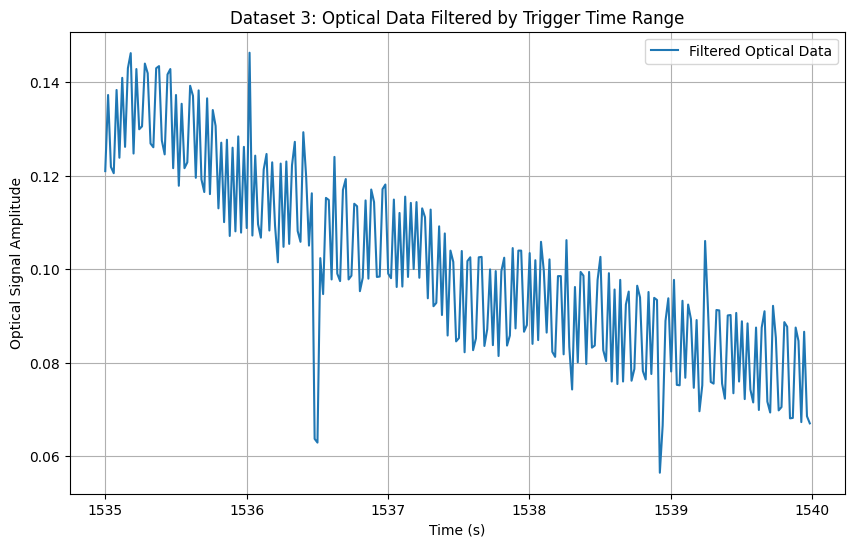

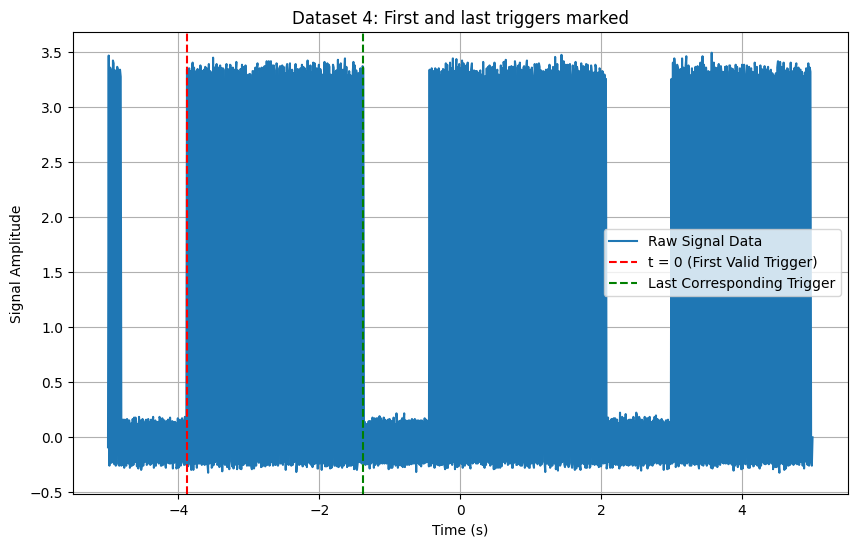

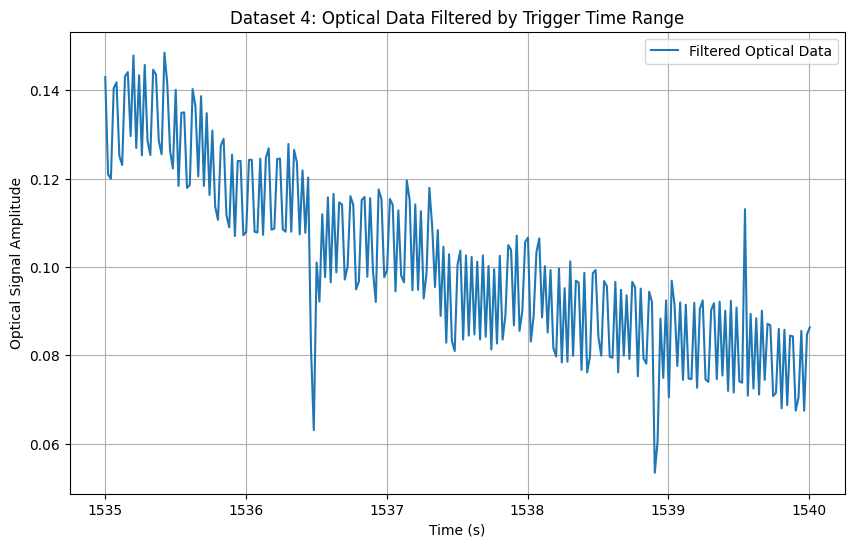

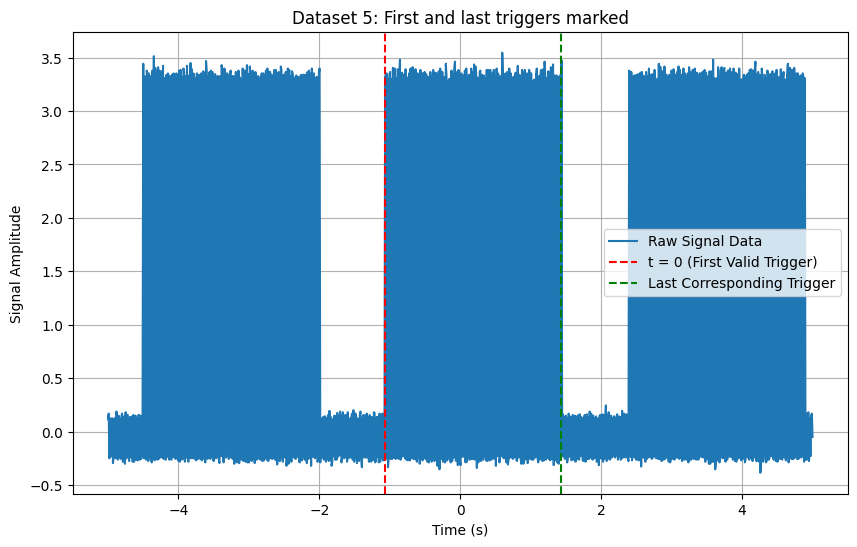

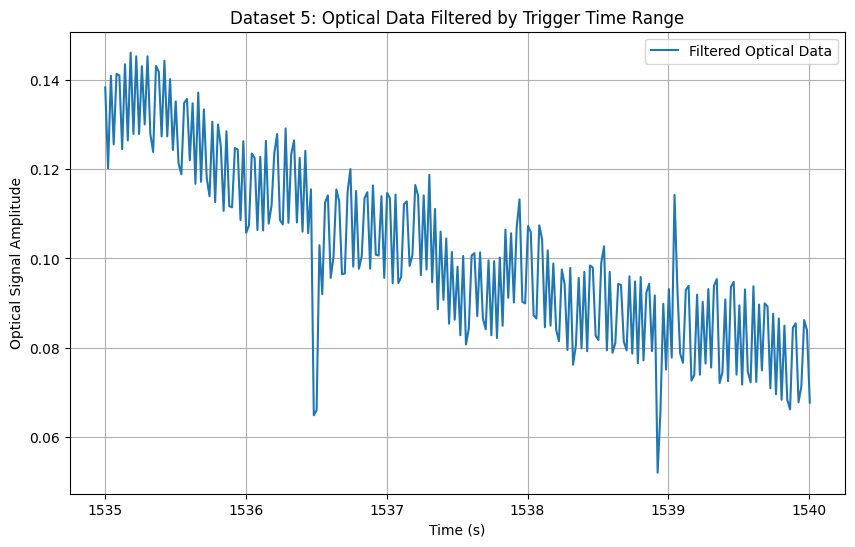

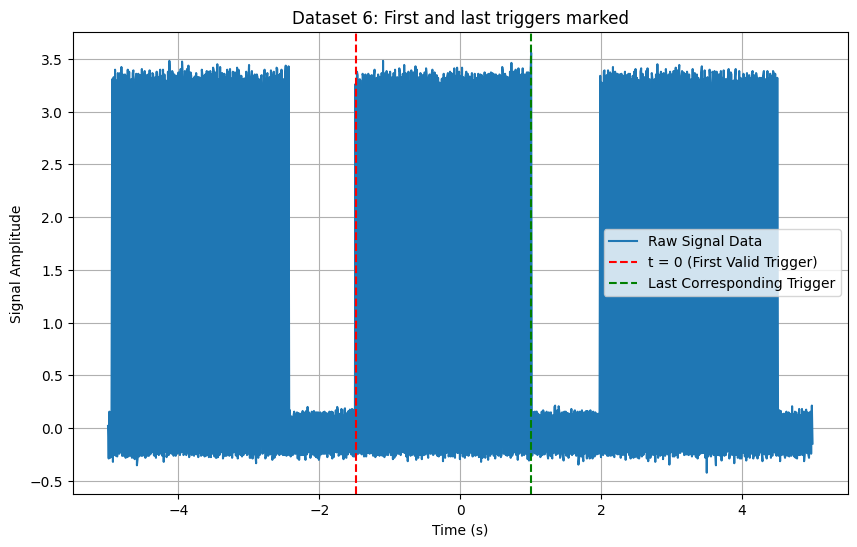

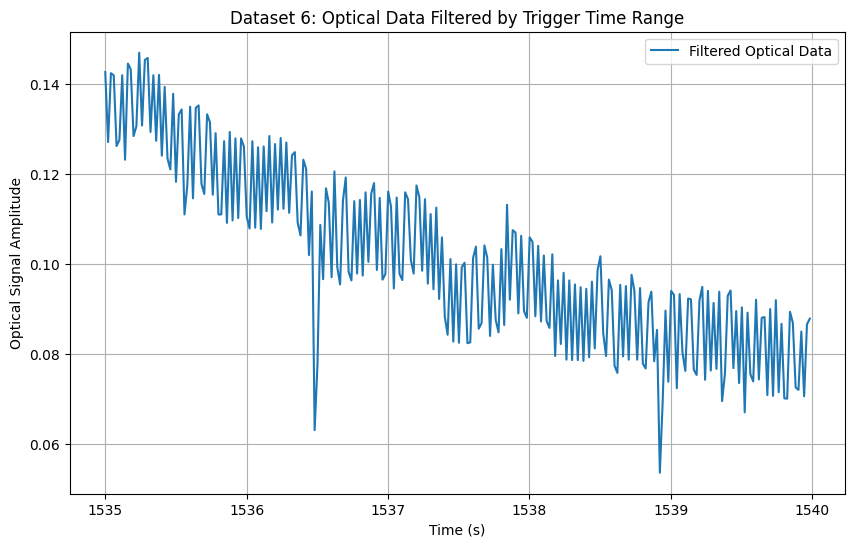

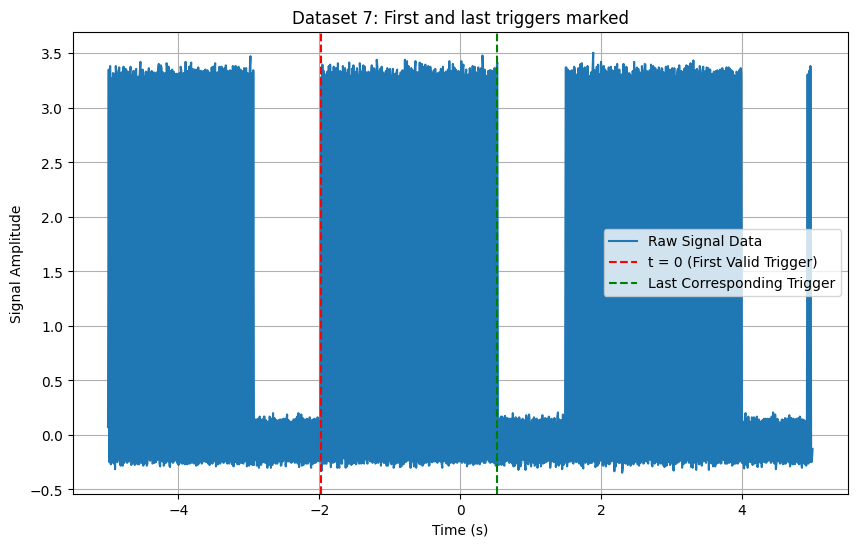

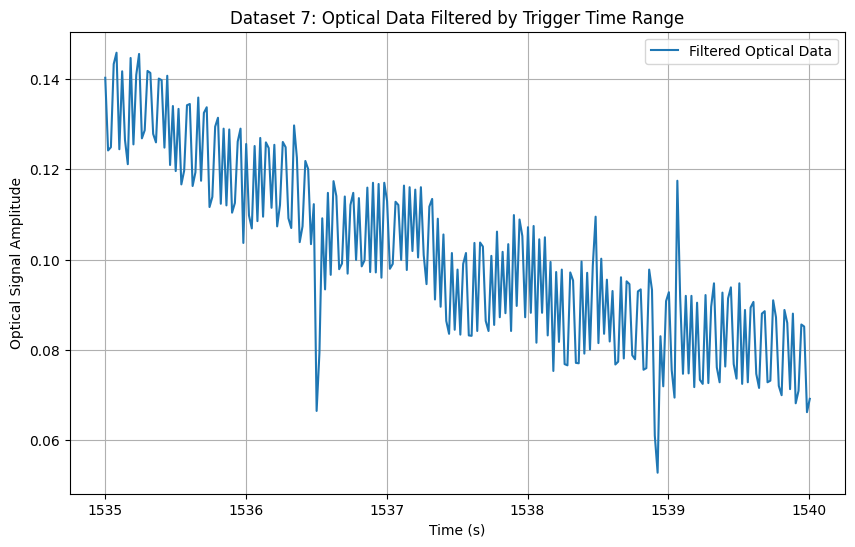

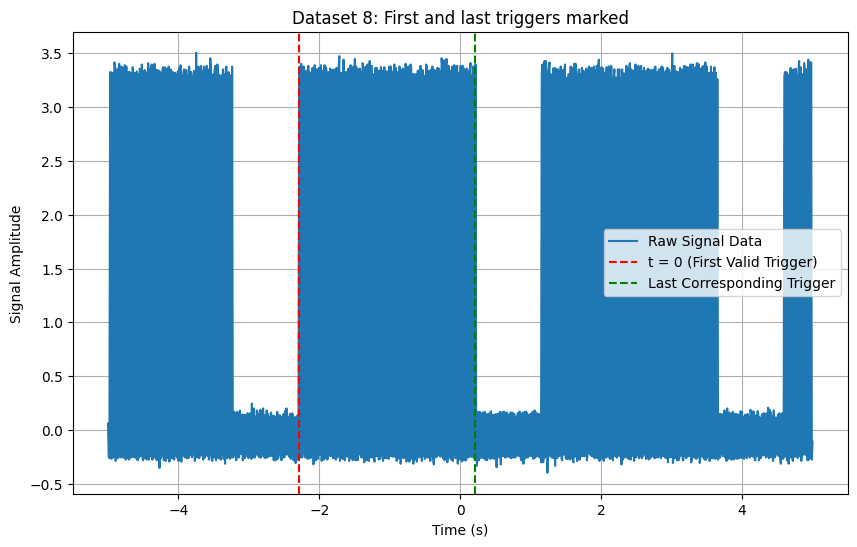

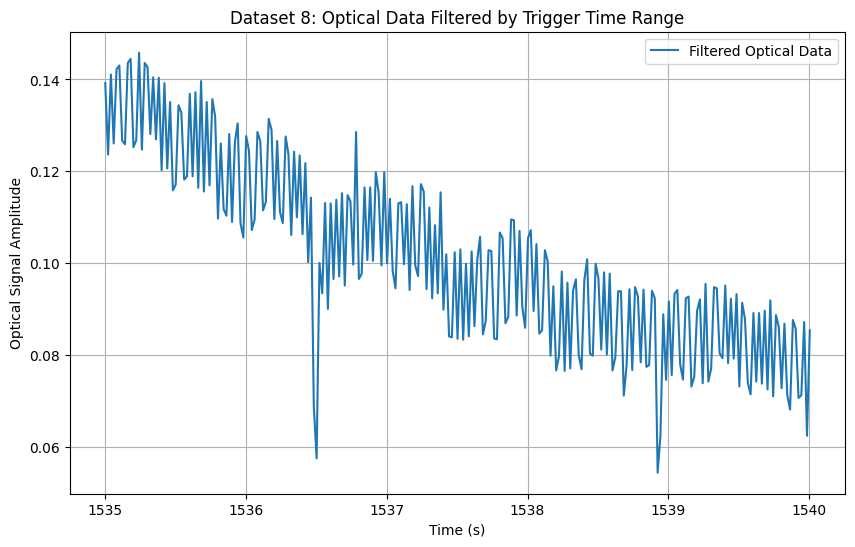

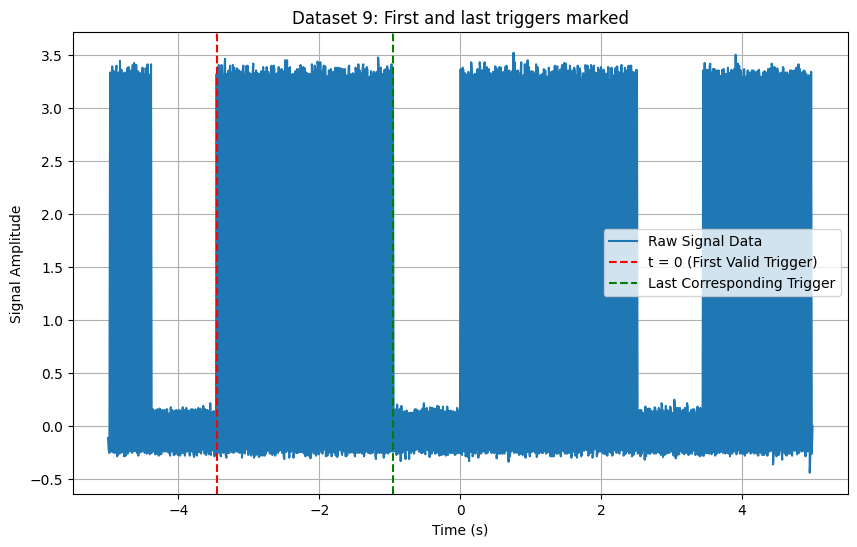

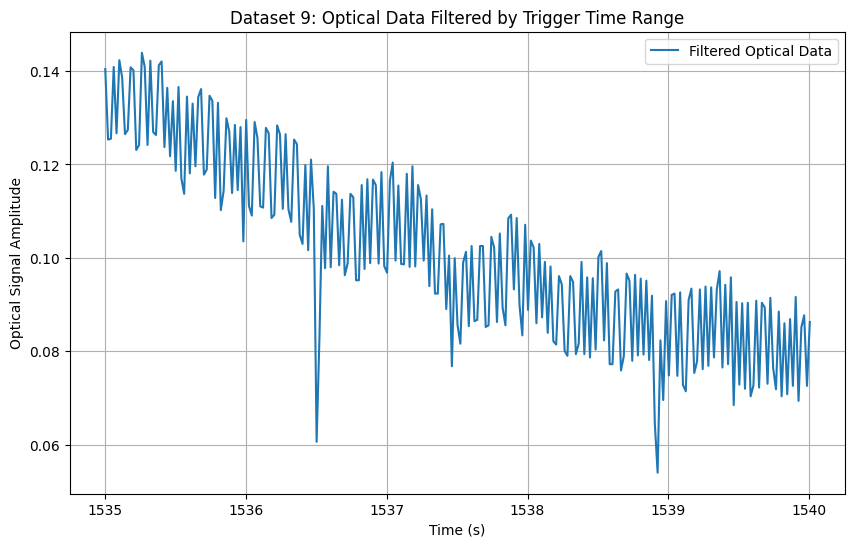

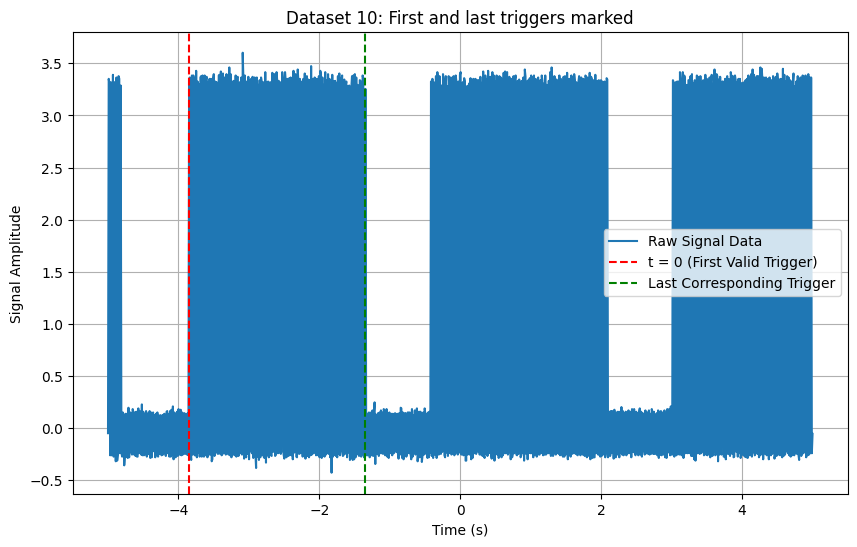

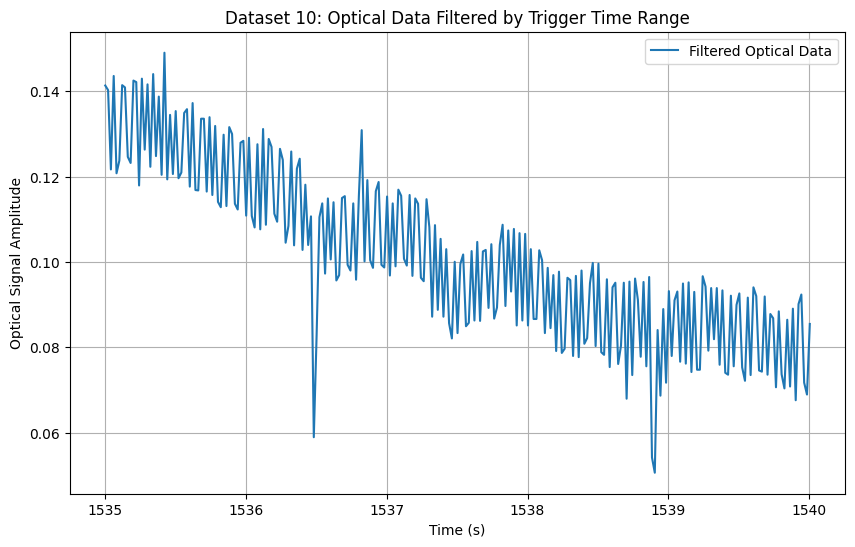

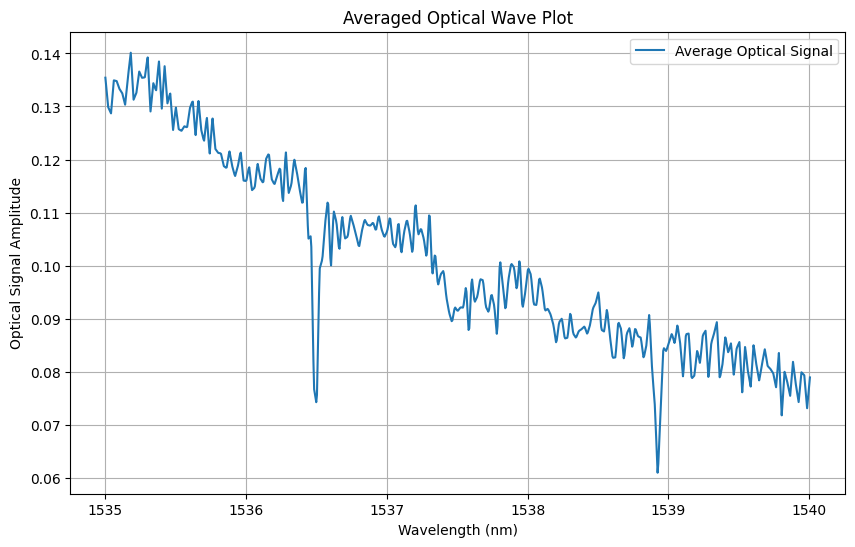

Waiting for 10.0 minutes before next capture


In [ ]:
# # Data collection of optical absorption

threshold = 1 # Voltage threshold for triggering
quiet_period_duration = 0.3  # Seconds of quiet period before checking
# WAV_START = 1535  # nm, already indicated beforehand
# speed = 1  # nm/s, already indicated beforehand

def setup_trigger(trigger_level, trigger_source='CHAN1'):
    """Function to set up and enable triggering"""
    # Set the trigger source (e.g., Channel 1)
    oscilloscope.write(f':TRIGger:EDGE:SOURce {trigger_source}')
    # Set the trigger level (e.g., 0.5V)
    oscilloscope.write(f':TRIGger:EDGE:LEVel {trigger_level}')
    # Set the trigger type (e.g., edge trigger on a rising edge)
    oscilloscope.write(':TRIGger:EDGE:SLOPe POSitive')
    # Set the trigger sweep mode
    oscilloscope.write(':TRIGger:SWEep SINGle')
    # print(f"Trigger set to {trigger_level}V on {trigger_source}.")


def plot_and_save_waveform(channels: list[int]):
    """Function to save the waveform as CSV file. Plot for sanity check"""
    
    for ch in channels:
        # Select the channel
        oscilloscope.write(f':WAV:SOUR CHAN{ch}')

        # Set the waveform format to ASCII (can also use 'BYTE' or 'WORD' for binary)
        oscilloscope.write(':WAV:FORM ASCII')

        # Get the waveform data
        print(f"Querying waveform data for channel {ch}")
        data = oscilloscope.query(':WAV:DATA?')

        # Parse the data (it's returned as a comma-separated string in ASCII mode)
        waveform_data = np.array([float(i) for i in data.split(',')])
        waveforms[f"waveform_ch{ch}"] = waveform_data

        # Get the X-axis scale and position (Time per division, etc.)
        x_increment = float(oscilloscope.query(':WAV:XINC?'))
        x_origin = float(oscilloscope.query(':WAV:XOR?'))

        # Generate the time axis
        time_axis = np.linspace(x_origin, x_origin + x_increment * len(waveform_data), len(waveform_data))
        waveforms[f"time_axis_ch{ch}"] = time_axis

        # Generate a timestamp for the file name
        timestamp = datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
        # Generate a datestamp for the overall folder name
        datestamp = datetime.now().strftime("%d.%m.%Y")
        
        # Define the folder path
        output_folder = f"C:/Users/groov/VSCode/CSV_Waveforms/{datestamp}"
        # Create the folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)
        
        if ch == 1:
            csvfilename = os.path.join(output_folder, f"{timestamp}_triggers_ch{ch}.csv")
            triggercsvfilenames.append(csvfilename)
        elif ch == 2:
            csvfilename = os.path.join(output_folder, f"{timestamp}_optical_ch{ch}.csv")
            opticalcsvfilenames.append(csvfilename)

        # Save the waveform data to a CSV file
        np.savetxt(csvfilename, np.column_stack((time_axis, waveform_data)), delimiter=",", header="Time, Amplitude")

    # # Plot the waveform for visualization and sanity check
    # plt.figure(figsize=(10, 6))
    # for ch in channels:
    #     plt.plot(waveforms[f"time_axis_ch{ch}"],  waveforms[f"waveform_ch{ch}"], label=f"channel {ch}")
    # plt.title("Waveform from Channels " + ", ".join(str(ch) for ch in channels))
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude (V)")
    # plt.grid(True)
    # plt.legend()
    # # plt.savefig(f"waveform_channel_{channel}_{timestamp}.png")
    # plt.show()

def load_data(file_path):
    """Load data from a CSV file."""
    data = pd.read_csv(file_path)
    time_data = data.iloc[:, 0].values
    signal_data = data.iloc[:, 1].values
    return time_data, signal_data


def find_first_trigger(time_data, signal_data, threshold=threshold, quiet_period_duration=quiet_period_duration):
    """Find the first valid trigger based on the threshold and quiet period."""
    # Identify indices where the signal exceeds the threshold
    trigger_indices = np.where(signal_data > threshold)[0]
    # print(f"Trigger indices (signal > {threshold}): {trigger_indices}")
    
    for i in range(len(trigger_indices) - 1):
        if time_data[trigger_indices[i+1]] - time_data[trigger_indices[i]] >= quiet_period_duration:
            return trigger_indices, trigger_indices[i+1], time_data[trigger_indices[i+1]]

    raise ValueError("No valid trigger found")


def find_last_trigger(time_data, trigger_indices, valid_trigger_index, quiet_period_duration=quiet_period_duration):
    """Find the last valid trigger within the same sweep as the first valid trigger. """

    # Filter triggers to only those occurring after the first valid trigger (t=0)
    post_t0_trigger_indices = trigger_indices[trigger_indices >= valid_trigger_index]
    # print(f"Post t=0 trigger indices: {post_t0_trigger_indices}")

    for i in range(len(post_t0_trigger_indices) - 1):
        # Check if the time difference satisfies the quiet period condition
        if time_data[post_t0_trigger_indices[i + 1]] - time_data[post_t0_trigger_indices[i]] >= quiet_period_duration:
            # print(f"Last valid trigger found at index {post_t0_trigger_indices[i]} with time {time_data[post_t0_trigger_indices[i]]}s.")
            return post_t0_trigger_indices[i], time_data[post_t0_trigger_indices[i]]

    # If no valid last trigger is found, the last trigger in the dataset is valid
    last_trigger_index = post_t0_trigger_indices[-1]
    print(f"Defaulting to the last trigger in the dataset at index {last_trigger_index} with time {time_data[last_trigger_index]}s.")
    return last_trigger_index, time_data[last_trigger_index]


################################# END OF FUNCTION DEFINITIONS, BEGINNING OF CODE ########################################## 

waveforms = {} # Initialise empty dictionary of waveforms

global_start_time = time.time()

# # Data acquisition pseudo-infinite loop
# # Stops based on auto timeout (24 hours)

while (time.time() - global_start_time) < 86400:

    # The ten files that get saved here will be cleared at the end of the while loop's 10 minute sleep.
    triggercsvfilenames = []
    opticalcsvfilenames = []

    print(f"Trigger set to {threshold}V on CHAN1.")

    # Turn on laser *just* before conducting sweeps
    TSL.write(":POWer:STATe 1")
    time.sleep(0.1)
    # # Settings implementation 
    TSL.write(f":POW {set_laser_power}")
    time.sleep(0.1)
    TSL.write(":WAVelength:SWEep 0")  # Engineering reset
    time.sleep(0.1)
    # Parameter writing
    TSL.write(f":WAVelength:SWEep:STARt {WAV_START}E-9") # Set start wavelength
    time.sleep(0.1)
    TSL.write(f":WAVelength:SWEep:STOP {WAV_END}E-9")   # Set stop wavelength
    time.sleep(0.1)
    TSL.write(f":WAVelength:SWEep:SPEed {speed}")  
    time.sleep(0.1)
    TSL.write(":WAVelength:SWEep:MODe 1")   # Continuous and one-way sweep, for finest wavelength change per unit time.
    time.sleep(0.1)
    TSL.write("TRIG:OUTP:STEP " + step_size)        # Time between triggers
    time.sleep(0.1)
    TSL.write(f"WAVelength:SWEep:DELay {delay_between_sweeps}")  # Reduce the delay between sweeps
    time.sleep(0.1)
    TSL.write(":WAVelength:SWEep 1")      # Begin sweeping   
    time.sleep(0.1)

    for i in range(10):     # 10 captures
        print(f"Capture {i+1}/10")
        
        oscilloscope.write(':STOP') # Quickly "engineering reset" the oscilloscope
        time.sleep(0.1) # Small delay to let oscilloscope settle before running and arming trigger

        oscilloscope.write(':RUN') # Need oscilloscope to start running before it can capture anything
        # The trigger will automatically start capturing once the trigger is detected

        setup_trigger(trigger_level=threshold)  # # Arm the trigger, Unit of trigger_level is V
        time.sleep(0.1) # Small delay to confirm trigger preparation
        
        while 1:
            if oscilloscope.query(':TRIGger:STATus?').strip() == 'TD':
                print("Triggered! Starting capture; it will stop by itself.")
                break

            elif oscilloscope.query(':TRIGger:STATus?').strip() == 'WAIT':
                continue

            else:
                pass

        while 1:
            if oscilloscope.query(':TRIGger:STATus?').strip() == 'STOP':
                plot_and_save_waveform(channels=[1,2])   # TODO: Write in the list of channel numbers that we wish to plot and save
                print("Frozen waveforms captured and saved as CSV")
                break
            
            else:
                time.sleep(0.1)  # Small delay to prevent busy-waiting
                pass
    
    # Out of the for-loop, done with 10 cycles of scanning 

    # Store interpolated signals for averaging
    common_wavelength = None
    interpolated_signals = []

    # Confirmation of t=0 times (first triggers) and corresponding last triggers
    for idx, (trigger_file, optical_file) in enumerate(zip(triggercsvfilenames, opticalcsvfilenames)):

        # Load trigger data
        trigger_time, trigger_signal = load_data(trigger_file)

        # Find the first valid trigger and mark t=0
        trigger_indices, valid_trigger_index, t0_reference = find_first_trigger(time_data=trigger_time, signal_data=trigger_signal)

        last_valid_trigger_index, t_end_time = find_last_trigger(time_data=trigger_time, trigger_indices=trigger_indices, valid_trigger_index=valid_trigger_index)

        # Plot the raw signal with t=0 marked
        plt.figure(figsize=(10, 6))
        plt.plot(trigger_time, trigger_signal, label="Raw Signal Data")
        plt.axvline(x=t0_reference, color='r', linestyle='--', label="t = 0 (First Valid Trigger)")
        plt.axvline(x=t_end_time, color='g', linestyle='--', label="Last Corresponding Trigger")
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Amplitude")
        plt.title(f"Dataset {idx + 1}: First and last triggers marked")
        plt.legend()
        plt.grid()
        plt.show()

        # Load optical data
        optical_time, optical_signal = load_data(optical_file)

        # Align optical data to t=0 from trigger data
        adjusted_optical_time = optical_time - t0_reference

        # Filter optical data to include only times between t=0 and t=end
        valid_optical_indices = (adjusted_optical_time >= 0) & (adjusted_optical_time <= (t_end_time - t0_reference))

        filtered_optical_time = adjusted_optical_time[valid_optical_indices]
        # Convert filtered optical time to wavelength

        filtered_optical_signal = optical_signal[valid_optical_indices]

        filtered_wavelength = WAV_START + speed * filtered_optical_time

        # Pre-averaging wavelength code
        # Plot the filtered optical data
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_wavelength, filtered_optical_signal, label="Filtered Optical Data")
        plt.xlabel("Time (s)")
        plt.ylabel("Optical Signal Amplitude")
        plt.title(f"Dataset {idx + 1}: Optical Data Filtered by Trigger Time Range")
        plt.legend()
        plt.grid()
        plt.show()

        # Create a common wavelength axis if not already created
        if common_wavelength is None:
            common_wavelength = np.linspace(min(filtered_wavelength), max(filtered_wavelength), 1000)  # 1000 points for interpolation

        # Interpolate the signal to the common wavelength axis
        interpolated_signal = np.interp(common_wavelength, filtered_wavelength, filtered_optical_signal)
        interpolated_signals.append(interpolated_signal)

        # print(f"Dataset {idx + 1} processed and interpolated.")

        # Compute the average signal
    interpolated_signals = np.array(interpolated_signals)  # Convert to NumPy array
    average_signal = np.mean(interpolated_signals, axis=0)

    # Plot the averaged optical wave plot
    plt.figure(figsize=(10, 6))
    plt.plot(common_wavelength, average_signal, label="Average Optical Signal")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Optical Signal Amplitude")
    plt.title("Averaged Optical Wave Plot")
    plt.legend()
    plt.grid()
    plt.show()  

    timestamp = datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
    csvfilename = f"C:/Users/groov/VSCode/CSV_Waveforms/final optical data/{timestamp}_average_filtered_optical_waveform_dataset.csv"
    np.savetxt(csvfilename, np.column_stack((common_wavelength, average_signal)), delimiter=",",header="Wavelength (nm), Optical Signal (V)")
    
    # Turn off laser after data has been collected
    TSL.write(":WAVelength:SWEep 0")
    time.sleep(0.1)
    TSL.write(":WAVelength 1550nm")
    time.sleep(0.1)
    TSL.write(":POWer:STATe +0")
    time.sleep(0.1)

    sleep_time = 10*60  # Time in seconds to wait before going to next capture
    print(f"Waiting for {sleep_time/60} minutes before next capture")
    time.sleep(sleep_time)  

In [ ]:
# # Explicit laser turn off
TSL.write(":WAVelength:SWEep 0")
time.sleep(0.1)
TSL.write(":WAVelength 1550nm")
time.sleep(0.1)
TSL.write(":POWer:STATe +0")
time.sleep(0.1)
print("Ensure the 'active' light is not green. If it is, press it")